In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import VESManager

import scipy.stats as stats
from scipy.stats import weibull_min

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [3]:
df = pd.read_csv("DATOS/modelos_sinteticos-SEV.csv")

In [4]:
df.describe()

,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,...,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,5.190400,17.729600,59.144000,183.283200,714.14640,1822.298400,2040.860000,1.120000,3.000000,5.320000,...,79.240000,87.04000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,7.579532,17.018282,42.084281,293.547888,1031.17125,2419.662453,2461.770902,0.331662,2.327373,4.028234,...,47.625518,53.29828,61.397258,67.619031,71.056011,76.897508,81.246497,86.544247,92.899803,102.919062
min,0.700000,4.500000,13.000000,1.000000,1.00000,13.400000,30.000000,1.000000,2.000000,3.000000,...,30.000000,32.00000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,2.360000,8.500000,37.200000,21.800000,48.00000,85.000000,129.000000,1.000000,2.000000,3.000000,...,54.000000,58.00000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,3.000000,13.000000,47.300000,56.600000,100.00000,1271.400000,1500.000000,1.000000,2.000000,4.000000,...,55.000000,60.00000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,5.600000,20.000000,63.000000,196.010000,1300.00000,2600.000000,2600.000000,1.000000,2.000000,4.000000,...,65.000000,70.00000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,40.000000,78.470000,204.000000,1300.000000,3350.00000,11000.000000,11000.000000,2.000000,10.000000,20.000000,...,200.000000,210.00000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000


📌 Mejor distribución: weibull_min
🔹 Parámetros: (0.7671316631205352, 0.6999999999999998, 21.907226262348598)
🔹 Estadístico KS: 0.0710533409489752
🔹 Valor p: 0.8173601019771459


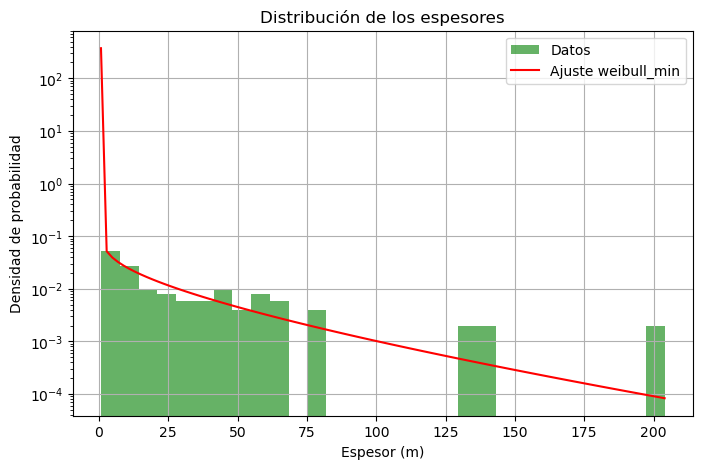

In [ ]:

# 🔹 Unir todas las columnas de espesores en un solo array
columnas_espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Asegúrate de incluir todas
todos_los_espesores = pd.concat([df[col] for col in columnas_espesores], ignore_index=True).dropna()

# 🔹 Distribuciones a evaluar
distribuciones = [stats.norm, stats.lognorm, stats.gamma, stats.expon, stats.weibull_min]
resultados = {}

# 🔹 Ajustar y evaluar cada distribución
for dist in distribuciones:
    params = dist.fit(todos_los_espesores)
    D, p_value = stats.kstest(todos_los_espesores, dist.cdf, args=params)
    
    resultados[dist.name] = {'params': params, 'KS_stat': D, 'p_value': p_value}

# 🔹 Ordenar por menor estadístico KS (mejor ajuste)
mejor_ajuste = sorted(resultados.items(), key=lambda x: x[1]['KS_stat'])[0]

# 🔹 Mostrar resultado
print("Mejor distribución:", mejor_ajuste[0])
print("🔹 Parámetros:", mejor_ajuste[1]['params'])
print("🔹 Estadístico KS:", mejor_ajuste[1]['KS_stat'])
print("🔹 Valor p:", mejor_ajuste[1]['p_value'])

# 🔹 Visualización de la distribución ajustada
plt.figure(figsize=(8, 5))
plt.hist(todos_los_espesores, bins=30, density=True, alpha=0.6, color='g', label="Datos")

# 🔹 Curva de la mejor distribución encontrada
x = np.linspace(min(todos_los_espesores), max(todos_los_espesores), 100)
pdf = mejor_ajuste[1]['params']
pdf_fitted = getattr(stats, mejor_ajuste[0]).pdf(x, *pdf)
plt.plot(x, pdf_fitted, 'r-', label=f"Ajuste {mejor_ajuste[0]}")

plt.title("Distribución de los espesores")
plt.xlabel("Espesor (m)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.yscale('log') 
plt.grid()
plt.show()

In [8]:

def mejor_distribucion(df, columnas):
    """
    Encuentra la mejor distribución para cada columna dada, basándose en la prueba de Kolmogorov-Smirnov.

    Parámetros:
    df : DataFrame
        Contiene los datos de entrada.
    columnas : list
        Lista de nombres de columnas a analizar.

    Retorna:
    DataFrame : Resumen de la mejor distribución para cada columna.
    """
    distribuciones = [stats.norm, stats.lognorm, stats.gamma, stats.expon, stats.weibull_min]
    resultados_finales = []

    for columna in columnas:
        datos = df[columna].dropna()
        resultados = {}

        for dist in distribuciones:
            params = dist.fit(datos)  
            D, p_value = stats.kstest(datos, dist.cdf, args=params)  

            resultados[dist.name] = {'params': params, 'KS_stat': D, 'p_value': p_value}

        # Seleccionar la mejor distribución (menor KS_stat)
        mejor_ajuste = min(resultados.items(), key=lambda x: x[1]['KS_stat'])

        # Almacenar resultados
        resultados_finales.append({
            'Columna': columna,
            'Mejor_Distribucion': mejor_ajuste[0],
            'KS_stat': mejor_ajuste[1]['KS_stat'],
            'p_value': mejor_ajuste[1]['p_value'],
            'Parametros': mejor_ajuste[1]['params']
        })

        # Mostrar resultados
        print(f"\nColumna: {columna}")
        print(f"Mejor distribución: {mejor_ajuste[0]}")
        print(f"KS_stat: {mejor_ajuste[1]['KS_stat']:.4f}, p_value: {mejor_ajuste[1]['p_value']:.4f}")
        print(f"Parámetros: {mejor_ajuste[1]['params']}")

    return pd.DataFrame(resultados_finales)

# Lista de columnas a analizar (incluyendo Espesor_3)
columnas_a_analizar = ['Espesor_1', 'Espesor_2', 'Espesor_3']
df_resultados = mejor_distribucion(df, columnas_a_analizar)

# Guardar resultados en un CSV
df_resultados.to_csv("mejores_distribuciones.csv", index=False)
print("\nResultados guardados en 'mejores_distribuciones.csv'")



Columna: Espesor_1
Mejor distribución: lognorm
KS_stat: 0.1335, p_value: 0.7155
Parámetros: (0.8831214429522092, 0.355992892090914, 3.004214766090959)

Columna: Espesor_2
Mejor distribución: lognorm
KS_stat: 0.0982, p_value: 0.9503
Parámetros: (1.0235925755546, 3.6857009990672074, 8.44439961328213)

Columna: Espesor_3
Mejor distribución: lognorm
KS_stat: 0.1523, p_value: 0.5566
Parámetros: (0.587487381169814, -0.9614186965651117, 50.23228493604447)

Resultados guardados en 'mejores_distribuciones.csv'


## Modelado de Rha 

In [ ]:
#limpieza de datos, eliminamos los registros con valores nulos Nan.. previamente se verifica pero se correo porsi acaso
df = df.dropna()

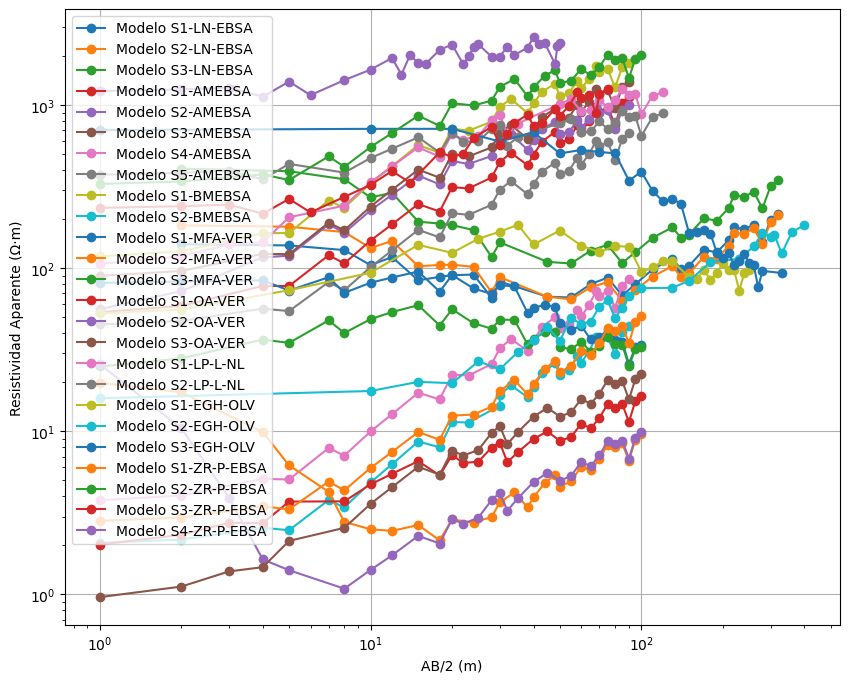

guardado 'RESULTADOS-Simulacion-Tesis.csv'


In [17]:

resultados = []
fig, ax = plt.subplots(figsize=(10, 8))
for _, row in df.iterrows():
    modelo_id = row["Modelo"]  # Nombre del modelo

    # 📌 Extraer espesores y resistividades
    espesores = row.filter(like="Espesor_").dropna().astype(str).replace("∞", "").astype(float).tolist()
    resistividades = row.filter(like="Resistividad_").dropna().astype(float).tolist()

    
    synthModel = espesores + resistividades# modelo sintético
  # extraemos los valores de apertura del arreglo que se empleara en la simulación
    ab2 = row.filter(like="AB2_").dropna().astype(float).values
     # se procede a generar la simulacion de la respuesta geolectrica en el subsuelo y graficamos el resultado, se agrega un nivel de ruido del 9%
 #Esta línea de código ejecuta la simulación de un sondeo eléctrico vertical (SEV) utilizando el método de resistividad aparente.
    ves = VESManager()
    rhoa, err = ves.simulate(synthModel, ab2=ab2, mn2=ab2 / 3, noiseLevel=0.09, seed=1337)
    #La función simulate() genera una curva de resistividad aparente para el modelo synthModel, 
    # #usando un conjunto de espaciados de electrodos (ab2) y aplicando ruido para simular condiciones reales.

    for i in range(len(ab2)):
        resultados.append([modelo_id, ab2[i], rhoa[i]])

    ax.plot(ab2, rhoa, 'o-', label=f"Modelo {modelo_id}")

df_resultados = pd.DataFrame(resultados, columns=["Modelo_ID", "AB2", "Resistividad_Aparente"])
df_resultados.to_csv("RESULTADOS-Simulacion-Tesis-2.csv", index=False)


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("AB/2 (m)")
ax.set_ylabel("Resistividad Aparente (Ω·m)")
ax.legend()
ax.grid()
plt.show()

print("guardado 'RESULTADOS-Simulacion-Tesis.csv'")

Parámetro	Descripción

synthModel: Lista con espesores y resistividades del modelo geológico.

ab2=ab2:   Arreglo con los valores de AB/2, que representa la distancia entre los electrodos de corriente en un SEV.

mn2=ab2 / 3:	Define la distancia entre los electrodos de potencial (MN/2), típicamente tomada como un tercio de AB/2.

noiseLevel=0.09:    Se agrega un 9% de ruido para simular la variabilidad real en los datos.

seed=1337:  Fija una semilla aleatoria para hacer que los resultados sean reproducibles.

In [18]:
df_resultados.describe()

,AB2,Resistividad_Aparente
count,750.000000,750.000000
mean,57.664000,367.586925
std,64.779397,514.618675
min,1.000000,0.961169
25%,15.000000,29.571502
50%,40.000000,116.735097
75%,75.000000,557.903541
max,400.000000,2611.167552


## Variantes de modelos

Apartir de los resultados anteriores se busca generar variacione de registros en donde el faactor variable corresponda al espesor de la sunidades, para ello se busca que se generen estas variaciones considerando la distribucion que mas se ajusta a la dispercion general de los datos.

Deacuardo a los datos de espesoires de los modelos originales, la distribucion para el conjunto de corresponde a weibull_min

 Mejor distribución: weibull_min

🔹 Parámetros: (0.7671316631205352, 0.6999999999999998, 21.907226262348598)

🔹 Estadístico KS: 0.0710533409489752

🔹 Valor p: 0.8173601019771459

In [21]:
# Parámetros de la distribución Weibull mínima
forma = 2.0  # Parámetro de forma (c)
escala = 5.0  # Parámetro de escala (scale)

# Lista para almacenar las nuevas filas
nuevas_filas = []

# Definir columnas de espesores
espesor_cols = ["Espesor_1", "Espesor_2", "Espesor_3"]  # Ajusta según sea necesario
num_variantes = 100  # Cantidad de variaciones por modelo

# Iterar sobre cada fila del DataFrame
for _, row in df.iterrows():
    modelo_base = row["Modelo"]
    suma_espesores = row[espesor_cols].sum()
    
    for i in range(1, num_variantes + 1):
        # Generar espesores con distribución Weibull mínima
        espesores_weibull = weibull_min.rvs(forma, loc=0, scale=escala, size=len(espesor_cols))

        # Normalizar para que sumen "suma_espesores"
        nuevos_espesores = (espesores_weibull / np.sum(espesores_weibull)) * suma_espesores
        
        # Crear una nueva fila con los valores generados
        nueva_fila = row.copy()
        nueva_fila[espesor_cols] = nuevos_espesores
        nueva_fila["Modelo"] = f"{modelo_base}_V{i}"
        nuevas_filas.append(nueva_fila)

# Convertir a DataFrame
df_variantes = pd.DataFrame(nuevas_filas)

# Exportar a CSV
output_path = "modelos_sinteticos_variaciones.csv"
df_variantes.to_csv(output_path, index=False)

# Vista previa
print(df_variantes.head())


          Modelo  Espesor_1  Espesor_2  Espesor_3  Resistividad_1  \
0  S1-LN-EBSA_V1  63.935070  53.239895  10.395035           150.0   
0  S1-LN-EBSA_V2  34.445106  71.991280  21.133614           150.0   
0  S1-LN-EBSA_V3  88.383972  30.823006   8.363022           150.0   
0  S1-LN-EBSA_V4  42.887142  43.802750  40.880109           150.0   
0  S1-LN-EBSA_V5  40.889714  28.671195  58.009091           150.0   

   Resistividad_2  Resistividad_3  Resistividad_4  AB2_1  AB2_2  ...  AB2_21  \
0            60.0           804.5           800.0      2      5  ...     150   
0            60.0           804.5           800.0      2      5  ...     150   
0            60.0           804.5           800.0      2      5  ...     150   
0            60.0           804.5           800.0      2      5  ...     150   
0            60.0           804.5           800.0      2      5  ...     150   

   AB2_22  AB2_23  AB2_24  AB2_25  AB2_26  AB2_27  AB2_28  AB2_29  AB2_30  
0     170     190     210   

In [22]:
df_variantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 0 to 24
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Modelo          2500 non-null   object 
 1   Espesor_1       2500 non-null   float64
 2   Espesor_2       2500 non-null   float64
 3   Espesor_3       2500 non-null   float64
 4   Resistividad_1  2500 non-null   float64
 5   Resistividad_2  2500 non-null   float64
 6   Resistividad_3  2500 non-null   float64
 7   Resistividad_4  2500 non-null   float64
 8   AB2_1           2500 non-null   int64  
 9   AB2_2           2500 non-null   int64  
 10  AB2_3           2500 non-null   int64  
 11  AB2_4           2500 non-null   int64  
 12  AB2_5           2500 non-null   int64  
 13  AB2_6           2500 non-null   int64  
 14  AB2_7           2500 non-null   int64  
 15  AB2_8           2500 non-null   int64  
 16  AB2_9           2500 non-null   int64  
 17  AB2_10          2500 non-null   int64  


In [23]:
df_variantes.describe()

,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,...,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,27.525916,27.565510,26.972573,183.283200,714.146400,1822.298400,2040.86000,1.120000,3.000000,5.320000,...,79.240000,87.040000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,21.781939,22.559146,21.534230,287.674557,1010.539488,2371.249641,2412.51558,0.325027,2.280807,3.947636,...,46.672623,52.231884,60.168817,66.266104,69.634316,75.358936,79.620911,84.812662,91.041056,100.859849
min,0.613901,0.303867,1.167459,1.000000,1.000000,13.400000,30.00000,1.000000,2.000000,3.000000,...,30.000000,32.000000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,13.897038,13.578605,13.723011,21.800000,48.000000,85.000000,129.00000,1.000000,2.000000,3.000000,...,54.000000,58.000000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,21.576174,20.775857,21.132326,56.600000,100.000000,1271.400000,1500.00000,1.000000,2.000000,4.000000,...,55.000000,60.000000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,32.528461,32.647191,31.400294,196.010000,1300.000000,2600.000000,2600.00000,1.000000,2.000000,4.000000,...,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,158.285248,167.374280,152.430053,1300.000000,3350.000000,11000.000000,11000.00000,2.000000,10.000000,20.000000,...,200.000000,210.000000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000


In [24]:
df.describe()

,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,AB2_2,AB2_3,...,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
count,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,5.190400,17.729600,59.144000,183.283200,714.14640,1822.298400,2040.860000,1.120000,3.000000,5.320000,...,79.240000,87.04000,94.960000,102.800000,108.960000,115.680000,122.920000,130.640000,138.960000,149.400000
std,7.579532,17.018282,42.084281,293.547888,1031.17125,2419.662453,2461.770902,0.331662,2.327373,4.028234,...,47.625518,53.29828,61.397258,67.619031,71.056011,76.897508,81.246497,86.544247,92.899803,102.919062
min,0.700000,4.500000,13.000000,1.000000,1.00000,13.400000,30.000000,1.000000,2.000000,3.000000,...,30.000000,32.00000,34.000000,38.000000,40.000000,42.000000,44.000000,48.000000,49.000000,50.000000
25%,2.360000,8.500000,37.200000,21.800000,48.00000,85.000000,129.000000,1.000000,2.000000,3.000000,...,54.000000,58.00000,60.000000,64.000000,68.000000,70.000000,75.000000,80.000000,85.000000,90.000000
50%,3.000000,13.000000,47.300000,56.600000,100.00000,1271.400000,1500.000000,1.000000,2.000000,4.000000,...,55.000000,60.00000,65.000000,70.000000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000
75%,5.600000,20.000000,63.000000,196.010000,1300.00000,2600.000000,2600.000000,1.000000,2.000000,4.000000,...,65.000000,70.00000,75.000000,80.000000,85.000000,90.000000,95.000000,100.000000,110.000000,120.000000
max,40.000000,78.470000,204.000000,1300.000000,3350.00000,11000.000000,11000.000000,2.000000,10.000000,20.000000,...,200.000000,210.00000,230.000000,260.000000,280.000000,300.000000,310.000000,330.000000,360.000000,400.000000
